In [1]:
## At the time of pulling the data, the abstracts # will be less because of not updating the abstract online in pubmed.

In [2]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
import spacy
import string


import pyLDAvis
import pyLDAvis.gensim_models
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

In [4]:
covid19 = pd.read_csv("../data/output/covid19_42022.csv")

In [5]:
covid19_abstract = covid19[['Abstract','Title']].dropna().reset_index(drop = True)

In [6]:

covid19_abstract.head()

,Abstract,Title
0,Population-based data on the current Covid-19 ...,[Evaluation of incidence and risk profile for ...
1,Approximately 20% of patients infected with SA...,Insights into the Use of C-Reactive Protein as...
2,Immediately after declaring COVID-19 as a pand...,Threat of COVID-19 Vaccine Hesitancy in Pakist...
3,This study aimed to evaluate the primary sympt...,"Primary Symptoms, Comorbidities, and Outcomes ..."
4,Reports of liver injury in patients with novel...,Patterns of liver injury in COVID-19 - a Germa...


In [7]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# clean the text using below for loop
clean_text = []
for index in tqdm(range(len(covid19_abstract))):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', covid19_abstract['Abstract'][index])

    #Convert to lowercase
    text = text.lower()
    
    #remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Convert to list of words from text
    text = text.split()
    
    # remove stop words after splitting text and join the words
    text =[word for word in text if word not in stop_words]
    text = " ".join(text)
    # lemmatize words using spacy
    
    doc = nlp(text)
    text=" ".join([token.lemma_ for token in doc])

   # append to clean_text
    clean_text.append(text)
    
covid19_abstract['clean_text'] = clean_text

100%|████████████████████████████████████████████████████████████████| 187007/187007 [29:31<00:00, 105.54it/s]


In [8]:
covid19_abstract.head()

,Abstract,Title,clean_text
0,Population-based data on the current Covid-19 ...,[Evaluation of incidence and risk profile for ...,population base datum current covid pandemic s...
1,Approximately 20% of patients infected with SA...,Insights into the Use of C-Reactive Protein as...,approximately patient infect sars cov covid de...
2,Immediately after declaring COVID-19 as a pand...,Threat of COVID-19 Vaccine Hesitancy in Pakist...,immediately declare covid pandemic numerous wi...
3,This study aimed to evaluate the primary sympt...,"Primary Symptoms, Comorbidities, and Outcomes ...",study aim evaluate primary symptom comorbiditi...
4,Reports of liver injury in patients with novel...,Patterns of liver injury in COVID-19 - a Germa...,report liver injury patient novel coronavirus ...


In [9]:
covid19_abstract.shape

(187007, 3)

In [10]:
covid19_abstract.to_csv('../data/output/covid19_42022_clean_text.csv', index = False)

In [11]:
covid19_abstract_clean = pd.read_csv("../data/output/covid19_42022_clean_text.csv")

In [12]:
covid19_abstract_clean.head()

,Abstract,Title,clean_text
0,Population-based data on the current Covid-19 ...,[Evaluation of incidence and risk profile for ...,population base datum current covid pandemic s...
1,Approximately 20% of patients infected with SA...,Insights into the Use of C-Reactive Protein as...,approximately patient infect sars cov covid de...
2,Immediately after declaring COVID-19 as a pand...,Threat of COVID-19 Vaccine Hesitancy in Pakist...,immediately declare covid pandemic numerous wi...
3,This study aimed to evaluate the primary sympt...,"Primary Symptoms, Comorbidities, and Outcomes ...",study aim evaluate primary symptom comorbiditi...
4,Reports of liver injury in patients with novel...,Patterns of liver injury in COVID-19 - a Germa...,report liver injury patient novel coronavirus ...


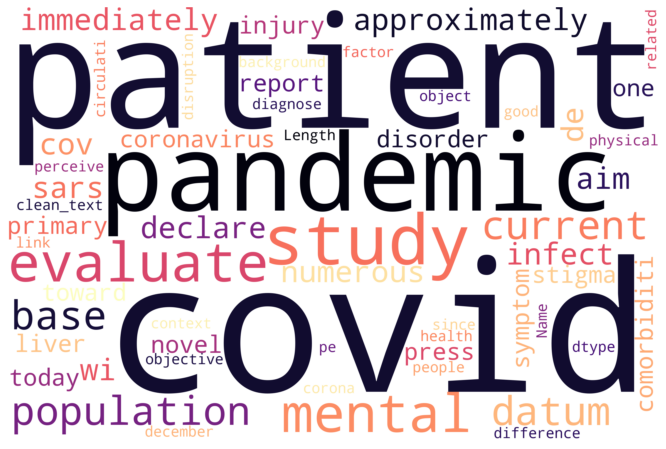

In [13]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(covid19_abstract_clean['clean_text']))

#print(wordcloud)
plt.figure(figsize = (30, 8), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/wordcloud_covid19.png")
plt.show()

In [14]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall','approximately','however', 'evaluates','base','clean_text','confirm','present','perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term','operate',
                'characteristics', 'whole','slide','supplementary', 'significantly', 'improvement','wide','range',
               'hand','craft','open','source','ci','see','outperform']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
216
395


In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(covid19_abstract_clean['clean_text'])

In [16]:
clean_text = [" ".join(x) for x in minus_stopwords]

clean_text[1]

'patient infect sars cov covid develop potentially life threaten pathology involve cytokine storm septic shock complication coagulation dysfunction organ failure blood prototypic acute phase reactant reactive protein crp hepatically synthesize release response interleukin stimulation markedly elevated patient covid markedly crp correlate poor prognosis survival insight crp structure relationship uncover pro anti inflammatory isoform monitor extent tissue damage associate covid pathology prognose herein rationale give interpretation crp blood simple rapid cost effective way assess disease severity help guide therapeutic option covid patient'

In [17]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

print(len(words_text))

['aim', 'primary', 'symptom', 'comorbiditie', 'outcome', 'inpatient', 'reverse', 'transcription', 'pcr', 'rt', 'pcr', 'sars', 'cov', 'infection', 'among', 'suspect', 'diagnose', 'case', 'covid', 'least', 'absolute', 'shrinkage', 'selection', 'operator', 'lasso', 'logistic', 'regression', 'age', 'suggestive', 'chest', 'ray', 'cxr', 'findings', 'sars', 'cov', 'infection', 'cardiovascular', 'disease', 'diabetes', 'mellitus', 'chronic', 'lung', 'disease', 'intensive', 'care', 'unit', 'admission', 'significant', 'association', 'rt', 'pcr', 'covid', 'infection', 'related', 'cough', 'dyspnea', 'abnormal', 'cxr', 'significant', 'predictor', 'symptom', 'include', 'cough', 'dyspnea', 'abnormal', 'cxr', 'could', 'proper', 'predictor', 'rt', 'pcr', 'sars', 'cov', 'infection', 'seem', 'patient', 'underlie', 'disease', 'cardiovascular', 'disease', 'diabetes', 'mellitus', 'chronic', 'lung', 'disease', 'probability', 'rt', 'pcr', 'sars', 'cov', 'infection', 'underlie', 'disease']
187007


In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
lemmatized_words = lemmatization(words_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [20]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                    Bigram         Freq
0           covid pandemic  2008.771243
1            covid patient  1329.680694
2        acute respiratory  1166.866382
3             severe acute  1027.338006
4      coronavirus disease  1019.623447
5     respiratory syndrome  1011.193303
6     syndrome coronavirus   936.300776
7            mental health   935.833621
8            disease covid   888.873011
9            patient covid   879.124696
10           public health   873.970855
11         covid infection   771.396977
12             health care   719.361997
13             risk factor   595.308504
14            severe covid   539.596775
15           covid vaccine   526.005709
16          intensive care   514.348510
17                year old   491.193386
18         immune response   469.879046
19              covid case   457.276435
20                age year   436.838235
21      infectious disease   428.119108
22            impact covid   420.215534
23               care unit   417.289196


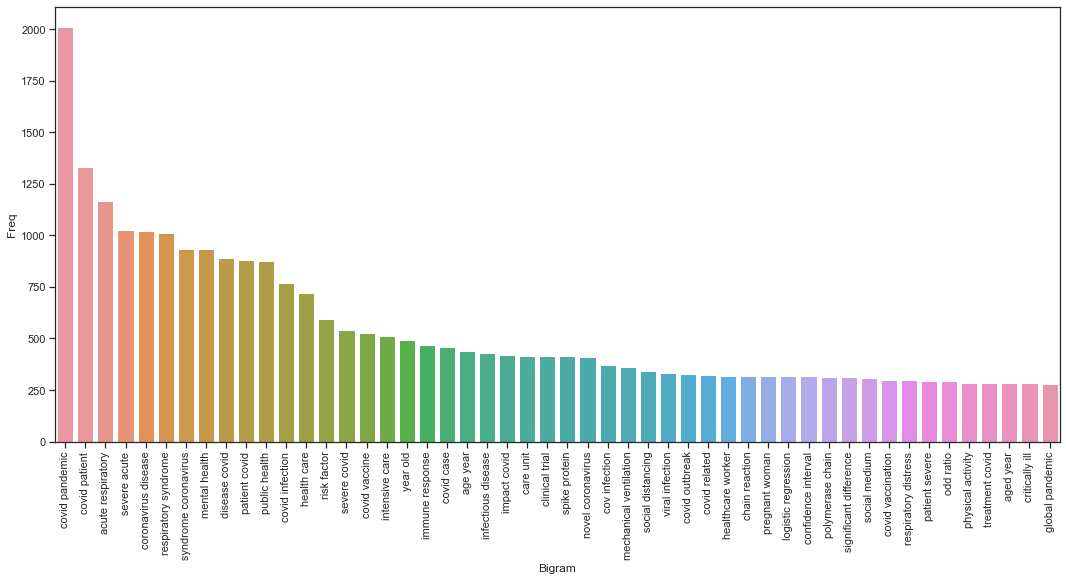

In [21]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in lemmatized_words]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 2,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

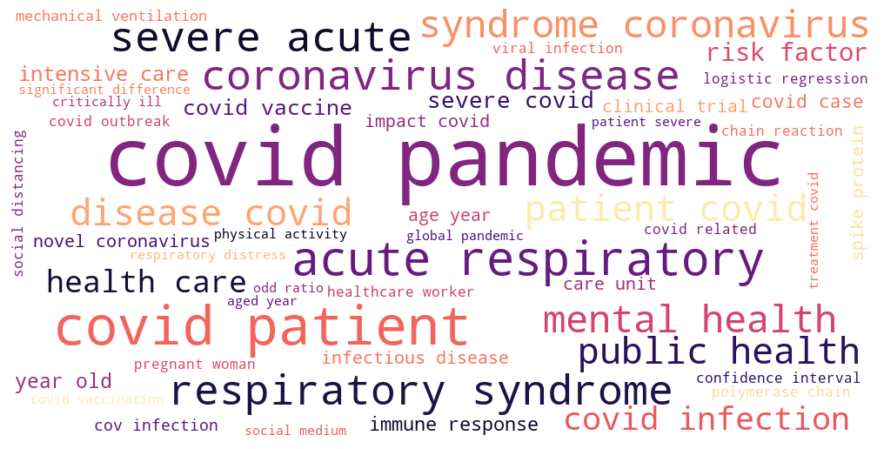

In [22]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                      relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (30, 8),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_covid19.png", bbox_inches='tight')
plt.show()

In [23]:
bigram = Phrases(lemmatized_words, min_count=1, threshold=100)
trigram = Phrases(lemmatized_words, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [24]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(lemmatized_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(lemmatized_words)

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 2), (2, 3), (3, 1), (4, 3), (5, 2), (6, 1), (7, 1), (8, 1), (9, 3), (10, 2), (11, 1), (12, 2), (13, 2), (14, 3), (15, 2), (16, 1), (17, 7), (18, 1), (19, 1), (20, 1), (21, 1), (22, 7), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 3), (32, 1), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 2), (51, 2), (52, 1), (53, 3), (54, 2), (55, 3), (56, 1), (57, 2), (58, 1), (59, 1), (60, 2), (61, 3), (62, 1), (63, 5), (64, 1), (65, 2), (66, 1), (67, 1), (68, 2), (69, 2), (70, 2), (71, 1), (72, 1), (73, 4)], [(5, 1), (17, 4), (22, 1), (26, 1), (39, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 4), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (1

In [26]:
id2word[21]

'diabete'

In [27]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=14, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=25,
                     alpha='auto',
                     per_word_topics=True)

In [28]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"covid" + 0.041*"child" + 0.038*"case" + 0.035*"symptom" + '
  '0.029*"patient" + 0.023*"report" + 0.018*"year" + 0.015*"diagnosis" + '
  '0.012*"clinical" + 0.012*"follow"'),
 (1,
  '0.188*"vaccine" + 0.105*"vaccination" + 0.040*"dose" + 0.024*"response" + '
  '0.023*"covid" + 0.019*"receive" + 0.019*"food" + 0.012*"second" + '
  '0.011*"efficacy" + 0.011*"antibody"'),
 (2,
  '0.137*"patient" + 0.050*"covid" + 0.023*"hospital" + 0.021*"group" + '
  '0.018*"day" + 0.017*"mortality" + 0.015*"admission" + 0.014*"outcome" + '
  '0.012*"care" + 0.012*"disease"'),
 (3,
  '0.055*"covid" + 0.030*"patient" + 0.026*"disease" + 0.014*"severe" + '
  '0.014*"inflammatory" + 0.013*"associate" + 0.011*"lung" + 0.010*"injury" + '
  '0.009*"infection" + 0.009*"immune"'),
 (4,
  '0.033*"covid" + 0.023*"health" + 0.023*"student" + 0.022*"pandemic" + '
  '0.021*"mental" + 0.021*"anxiety" + 0.019*"stress" + 0.019*"social" + '
  '0.015*"report" + 0.015*"participant"'),
 (5,
  '0.044*"drug" + 

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.555543168134406

Coherence Score:  0.5560599344737046


In [30]:
# code repurposed from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

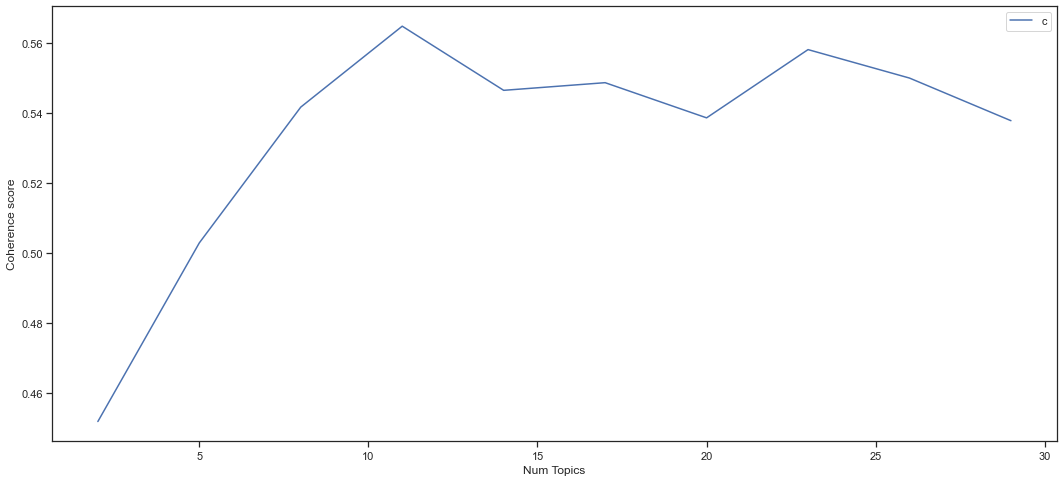

In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/bhargavihari/miniforge3/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhargavihari/miniforge3/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhargavihari/miniforge3/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhargavihari/miniforge3/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import rel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.067939  0.011806       1        1  18.894960
4     -0.095873 -0.033254       2        1  10.117702
9     -0.006361  0.017065       3        1   9.470336
2     -0.229213  0.044169       4        1   9.224308
12     0.061560  0.172501       5        1   7.325726
6      0.260848  0.087591       6        1   6.304089
7     -0.170588  0.035694       7        1   6.181999
11    -0.112528 -0.100669       8        1   6.097609
3     -0.014560  0.169713       9        1   5.998018
0     -0.152705  0.046286      10        1   5.177264
8     -0.039638 -0.125047      11        1   4.670824
5      0.256618  0.041821      12        1   4.511785
10     0.064243 -0.041840      13        1   3.930674
1      0.110257 -0.325835      14        1   2.094706, topic_info=            Term           Freq          Total Category  logprob  loglift
108      patient  338804.000000  338804.000000  Default  30.0000  30.0000
206      vaccine   68004.000000   68004.000000  Default  29.0000  29.0000
215         care   93400.000000   93400.000000  Default  28.0000  28.0000
71   vaccination   37901.000000   37901.000000  Default  27.0000  27.0000
17         covid  512420.000000  512420.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
27         first    3207.409880   43408.992350  Topic14  -4.7242   1.2606
597       follow    2695.663537   44349.733880  Topic14  -4.8980   1.0653
40           low    2657.952910   63680.928134  Topic14  -4.9121   0.6894
88     effective    2413.264611   26450.748406  Topic14  -5.0087   1.4715
55    population    2412.251139   49449.676216  Topic14  -5.0091   0.8454

[979 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4496      7  0.998660              aa
4167     10  0.998470  abdominal_pain
4042     14  0.999741      acceptance
464       1  0.999937          access
1680      6  0.999885             ace
...     ...       ...             ...
1678      2  0.192765           young
1678      7  0.641935           young
1678     10  0.165269           young
4253      4  0.999533           youth
4930      6  0.999368        zoonotic

[2194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 10, 3, 13, 7, 8, 12, 4, 1, 9, 6, 11, 2])

In [33]:
pyLDAvis.save_html(vis, '../data/ldacovid.html')

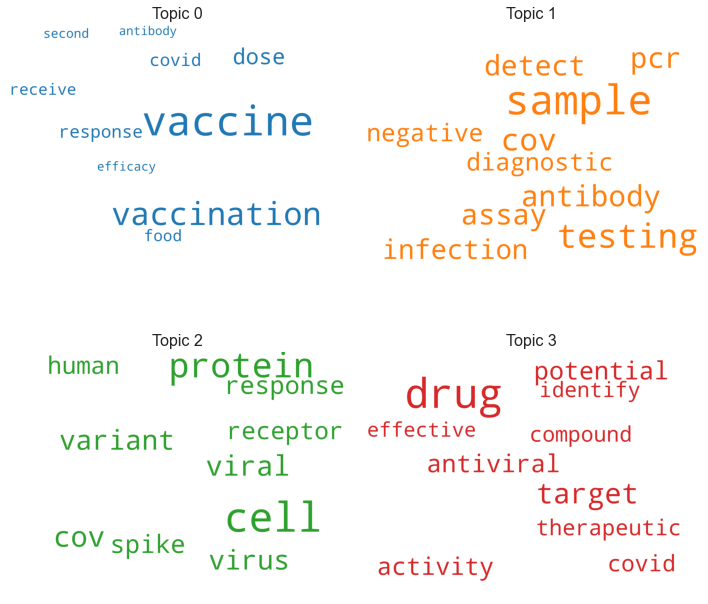

In [34]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("../data/topic_words_covid19.png", bbox_inches='tight')
plt.show()